## Setting up

In [1]:
from math import sqrt, exp as mexp

# import numpy functions
from numpy import (
    vectorize, linspace, logspace, arange, zeros, log10, fill_diagonal, 
    exp, pi, set_printoptions, log2, inf, array, ndarray, diagonal,
    sin, cos, sinh, sqrt as nsqrt, log, sin, ones, finfo, meshgrid, where, union1d, 
    eye, count_nonzero, savetxt
)
from scipy.sparse import diags as spdiags, eye as speye, kron as spkron
from scipy.sparse import isspmatrix_csr, isspmatrix_lil
from scipy.sparse.linalg import spsolve
from numpy.linalg import solve, norm

from scipy.interpolate import interp2d


import sys

# set to print lines to large width
set_printoptions(linewidth=500)

from itertools import cycle

%matplotlib inline
from matplotlib.style import use
# use("seaborn")

# import the default plot settings
from pltconfig import *

from matplotlib.pyplot import figure
from mpl_toolkits.mplot3d.axes3d import get_test_data
# This import registers the 3D projection, but is otherwise unused.

# Problem 2

## Part A

In [2]:
class q2a(object):
    
    def __init__(
        self, m=50, n=50, a=0.0, b=0.5*pi, c=0.0, d=pi, with_corrections=False
        ):
        
        # assign input variables
        self.m = m
        self.a = a
        self.b = b
        self.n = n
        self.c = c
        self.d = d
        
        # compute derived variables
        # set up grid in x-direction
        self.Lx = b-a
        self.dx = self.Lx/(m+1)
        self.xpts = linspace(a, b, m+2)
        
        # set up grid in y-direction
        self.Ly = d-c
        self.dy = self.Ly/(n+1)
        self.ypts = linspace(c, d, n+2)
        
        self.xxn, self.yyn = meshgrid(self.xpts, self.ypts, indexing="ij")
        # get the interior mesh
        self.xxv, self.yyv = self.xxn.T.flatten(), self.yyn.T.flatten()
        
        # get boundary conditions
        self.ut = 0.0
        self.ub = 0.0
        self.ul = -sin(2*self.ypts)
        self.ur = 0.5*sinh(0.5*pi)*sin(self.ypts)
                
        # construct A matrix
        self.A = self.get_A()
        
        # construct F
        if not with_corrections:
            self.fvec, self.F = self.get_F()
        else:
            self.fvec, self.F = self.get_F_deferred()
        
        # get solution 
        self.uvec, self.U = self.get_soln()

    def get_A(self):
        
        """Get the A matrix on LHS with boundary conditions built in"""
        
        # unload the variables
        m = self.m
        a = self.a
        b = self.b
        dx = self.dx
        xxv = self.xxv
        
        n = self.n
        c = self.c
        d = self.d
        dy = self.dy
        yyv = self.yyv
        
        # define internal arrays
        onez = ones(max(m,n)+2)
        _internal = array([1, -2, 1])
        
        # set up differentiation matrix
        D2x = spdiags(_internal[:,None]*onez[None,:], [-1, 0, 1], (m+2,m+2))
        Ix = speye(m+2)
        
        D2y = spdiags(_internal[:,None]*onez[None,:], [-1, 0, 1], (n+2,n+2))
        Iy = speye(n+2)
        
        # cosntruct a sparse lil matrix from differentiation matrices
        A = (spkron(Iy, D2x)/(dx*dx) + spkron(D2y, Ix)/(dy*dy)).tolil()
        
        # build in the boundary conditions
        bcxid = union1d(where(xxv==a), where(xxv==b))
        bcyid = union1d(where(yyv==c), where(yyv==d))
        bcids = union1d(bcxid, bcyid)
        nbcpts = bcids.size
        A[bcids,:] = zeros((nbcpts, (m+2)*(n+2)))
        A[bcids[:,None],bcids[None,:]] = eye(nbcpts)
        
        del bcxid, bcyid, bcids, nbcpts

        return A.tocsr() # ensure that matrix returned is efficient for computation
    
    def get_F(self):
        
        xxn = self.xxn
        ut = self.ut
        ub = self.ub
        
        yyn = self.yyn
        ul = self.ul
        ur = self.ur
        
        # define the right-hand side. 
        # the grid is set up so that x goes across the columns LEFT-TO-RIGHT
        # and y goes DOWN the rows
        f = 13.0*cos(3*xxn)*sin(2*yyn)
        
        # Impose BCs at x = a,b and at y = c,d
        # x BCs
        f[0,:] = ul # x = a
        f[-1,:] = ur # @ x = b
        # y BCs
        f[:,0] = ub # @ y = c
        f[:,-1] = ut # @ y = d        
        
        return f, f.T.flatten()
    
    def get_F_deferred(self):
        
        xxn = self.xxn
        ut = self.ut
        ub = self.ub
        
        yyn = self.yyn
        ul = self.ul
        ur = self.ur
        
        # define the right-hand side. 
        # the grid is set up so that x goes across the columns LEFT-TO-RIGHT
        # and y goes DOWN the rows
        f = 13.0*cos(3*xxn)*sin(2*yyn) - ((self.dx**2)/12)*169*cos(3*xxn)*sin(2*yyn)
        
        # Impose BCs at x = a,b and at y = c,d
        # x BCs
        f[0,:] = ul # x = a
        f[-1,:] = ur # @ x = b
        # y BCs
        f[:,0] = ub # @ y = c
        f[:,-1] = ut # @ y = d        
        
        return f, f.T.flatten()
    
    def get_soln(self):
        soln = spsolve(self.A, self.F)
        return soln, soln.reshape((self.m+2,self.n+2), order="F")
    
    def exact_soln(self, x, y):
        return 0.5*sinh(x)*sin(y)-cos(3*x)*sin(2*y)
        
    def get_plot(self,target_file="q2a_figure.pdf"):
        
        fig = figure(figsize=(17,10))
        
        # check the mesh
        ax0 = fig.add_subplot(2, 3, 1)
        ax0.plot(self.xxv, self.yyv, "o", ms=14)
        ax0.set_ylim([self.c, self.d])
        ax0.set_xlim([self.a, self.b])
        ax0.set_xlabel(r"$x$", fontsize=18)
        ax0.set_ylabel(r"$y$", fontsize=18)
        ax0.set_title(
            f"Computational mesh: {self.m+2} x {self.n+2} = {self.xxv.size} points; dx = {self.dx:.3f}, dy = {self.dy:.3f}", 
            fontsize=13
            )
        
        # spy the matrix A
        ax1 = fig.add_subplot(2, 3, 2)
        ax1.spy(self.A)
        ax1.set_xlabel(f"nz = {count_nonzero(self.A.toarray())}",fontsize=18)
        ax1.set_ylabel(f"Spy(A)", fontsize=18)
        ax1.yaxis.set_label_position("right")
        
        # plot the computed solution        
        ax2 = fig.add_subplot(2, 3, 3, projection='3d')
        X, Y = meshgrid(self.xpts, self.ypts, indexing="ij")
        ax2.plot_surface(X, Y, self.U)
        ax2.set_xlabel(r"$x$", fontsize=20)
        ax2.set_ylabel(r"$y$", fontsize=20)
        ax2.set_zlabel(r"$u$", fontsize=20)
        
        # find the inf-norm maximum error
        maxerr_soln = norm(self.U.flatten()-self.exact_soln(X, Y).flatten(), ord=inf)
        ax2.set_title(f"Computed solution; max. error = {maxerr_soln:.4f}")
        
        ax3 = fig.add_subplot(2, 3, 4)
        cs = ax3.contour(self.xpts, self.ypts, self.U.T)
        ax3.clabel(cs)
        ax3.set_xlabel(r"$x$", fontsize=20)
        ax3.set_ylabel(r"$y$", fontsize=20)
        ax3.set_title(f"Contour plot of the computed solution", fontsize=20)
        
        # interpolate solution on finer grid
        xxfine = linspace(self.a, self.b, 2*self.m+3)
        yyfine = linspace(self.c, self.d, 2*self.n+3)
        
        xxx, yyy = meshgrid(xxfine, yyfine, indexing="xy")
        f = interp2d(self.xpts, self.ypts, self.U.T, kind="cubic")
        uuu = f(xxfine, yyfine)
        
        ax4 = fig.add_subplot(2, 3, 5, sharey=ax3)
        cs2 = ax4.contour(xxfine, yyfine, uuu)
        ax4.clabel(cs2)
        ax4.set_xlabel(r"$x$", fontsize=20)
        ax4.set_ylabel(r"$y$", fontsize=20)
        ax4.set_title(f"Contour plot of the fine solution", fontsize=20)
        
        ax5 = fig.add_subplot(2, 3, 6, projection='3d')
        ax5.plot_surface(xxx, yyy, uuu)
        ax5.set_xlabel(r"$x$", fontsize=20)
        ax5.set_ylabel(r"$y$", fontsize=20)
        ax5.set_zlabel(r"$u$", fontsize=20)
        ax5.zaxis.set_label_position("top")
        
        # find the inf-norm maximum error
        maxerr_interp = norm(uuu-self.exact_soln(xxx, yyy), ord=inf)
        ax5.set_title(f"Solution on fine grid; max. error = {maxerr_interp:.4f}")
        
        fig.tight_layout()
        fig.subplots_adjust(right=0.98)
        fig.savefig(target_file)

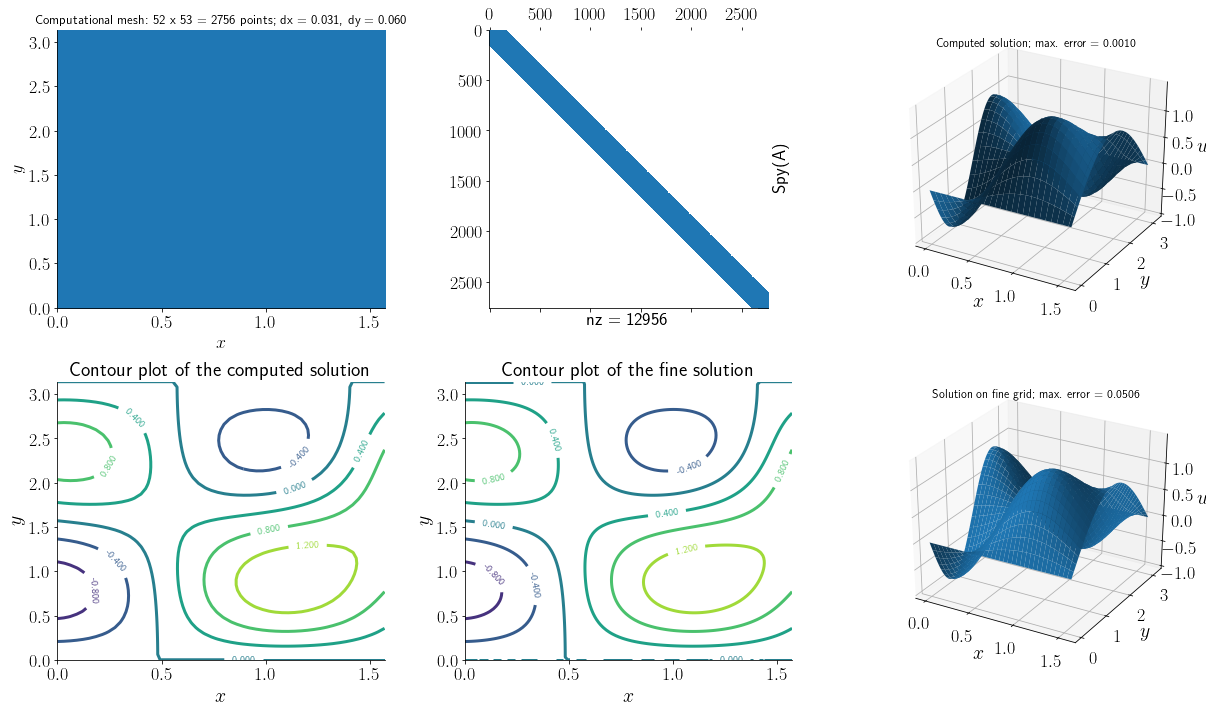

In [3]:
sample = q2a(m=50,n=51)
sample.get_plot()

In [4]:
def q2a_compute_grid_error_scaling(n=9):
    
        # initialize array for storage
        Nvals = zeros(n)
        error_array1_infnorm = zeros(n)

        # set the number of initial number of internal points
        m_coarse = (2**2)

        print(f"N    inf-norm error    ratio (inf-norm)    order (inf-norm)")
        
        for i in range(n):

            # construct the meshes and solve 
            soln_coarse = q2a(m=m_coarse,n=m_coarse)

            # compute the errors using the infinity-norm
            error_array1_infnorm[i] = norm(
                soln_coarse.U.flatten()-soln_coarse.exact_soln(soln_coarse.xxn, soln_coarse.yyn).flatten(), 
                ord=inf
            )

            # record the number of intervals
            Nvals[i] = m_coarse + 1
            
            if (i > 0):
                print(
                    f"{m_coarse+1:<5d}"
                    + f"{error_array1_infnorm[i]:<18.2e}"
                    + f"{error_array1_infnorm[i]/error_array1_infnorm[i-1]:<20.5f}"
                    + f"{-log((error_array1_infnorm[i]/error_array1_infnorm[i-1]).__abs__())/log(2):<16.5f}"
                    )
            else:
                print(
                    f"{m_coarse+1:<5d}"
                    + f"{error_array1_infnorm[i]:<18.2e}"
                    )
                
            # set the current fine grid as the coarse grid for next iteration
            m_coarse = 2*m_coarse + 1

        return Nvals, error_array1_infnorm

In [5]:
def plot_2a():
    
    Nvals, error_array1_infnorm = q2a_compute_grid_error_scaling(n=6)

    fig, ax = subplots(1,1,figsize=(10,10))

    ax.loglog(Nvals, error_array1_infnorm, lw=3.0, label="inf-norm")

    ax.loglog(Nvals, 1./(Nvals**2), lw=3.0, ls="--", color="gray", label=r"reference $N^{-2}$ line")
    
    ax.legend(loc=0, prop={"size":18})
    ax.set_ylabel(r"$E(N)$", fontsize=28)
    ax.set_xlabel(r"$N$", fontsize=28)
    ax.tick_params(labelsize=28)
    ax.grid(True)

    fig.tight_layout()
    fig.savefig("q2a_err_fig.pdf")

N    inf-norm error    ratio (inf-norm)    order (inf-norm)
5    1.05e-01          
10   2.52e-02          0.24017             2.05789         
20   6.62e-03          0.26275             1.92826         
40   1.65e-03          0.24925             2.00436         
80   4.12e-04          0.24981             2.00109         
160  1.03e-04          0.25000             2.00002         


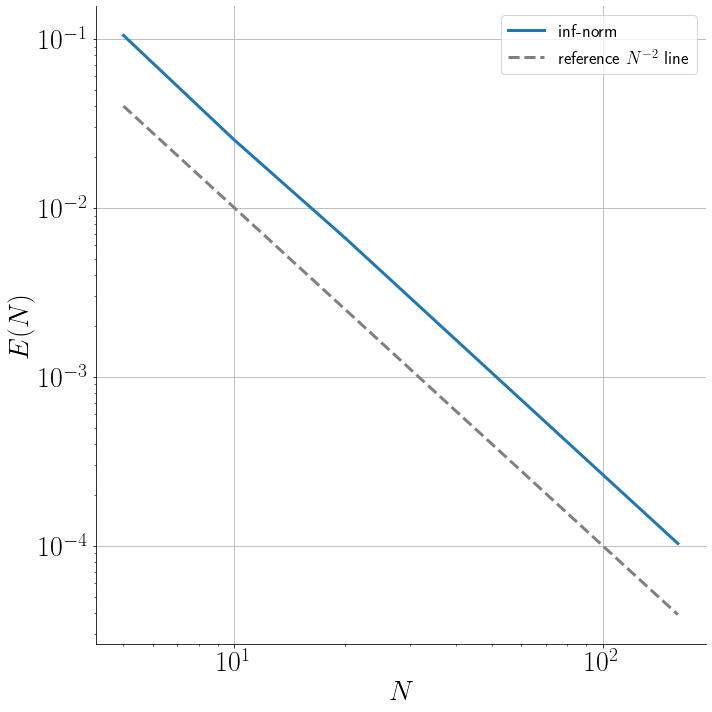

In [6]:
plot_2a()

## Part B

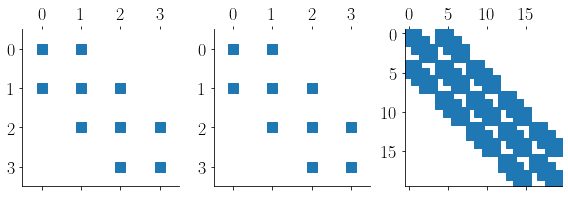

In [7]:
m = 2; n = 3

# define internal arrays
onez = ones(max(m,n)+2)
_internal_ref = array([1, -2, 1])
_internal0 = array([4, -20, 4])
_internal1 = array([1, 4, 1])

# set up differentiation matrix
T_1 = spdiags(_internal0[:,None]*onez[None,:], [-1, 0, 1], (m+2,m+2))

# create a matrix with ones on super and sub-diagonals and zeros on diagonal
I_off = speye(n+2, k=1) + speye(n+2, k=-1)
        
T_2 = spdiags(_internal1[:,None]*onez[None,:], [-1, 0, 1], (m+2,m+2))
Identity = speye(n+2)

# cosntruct a sparse lil matrix from differentiation matrices
A = (spkron(Identity, T_1) + spkron(I_off, T_2)).tolil()

savetxt("matrix_1.txt", spkron(Identity, T_1).toarray(), fmt="%5.1f")
savetxt("matrix_2.txt", spkron(I_off, T_2).toarray(), fmt="%5.1f")
savetxt("matrix.txt", A.toarray(), fmt="%5.1f")

fig, (ax0, ax1, ax2) = subplots(1,3,figsize=(8,8))
ax0.spy(T_1)
ax1.spy(T_2)
ax2.spy(A)
fig.tight_layout()

In [8]:
class q2b(q2a):
    
    # This object inherits from q2a but has 
    # a different definition of the LHS matrix A
    
    def __init__(
        self, m=50, a=0.0, b=0.5*pi, c=0.0, d=pi, with_corrections=False
        ):
        
        # assign input variables
        self.m = m
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        
        # compute derived variables
        # set up grid in x-direction
        self.Lx = b-a
        self.dx = self.Lx/(m+1)
        self.xpts = linspace(a, b, m+2)
        
        # set up grid in y-direction
        # set up grid in y-direction such that the spacing between
        # the points on the grid is the same as in the x-direction
        self.Ly = d-c
        self.n = int(((self.Ly/self.Lx)*(self.m+1))-1.0)
        self.dy = self.Ly/(self.n+1)
        self.ypts = linspace(c, d, self.n+2)
        
        self.xxn, self.yyn = meshgrid(self.xpts, self.ypts, indexing="ij")
        # get the interior mesh
        self.xxv, self.yyv = self.xxn.T.flatten(), self.yyn.T.flatten()
        
        # get boundary conditions
        self.ut = 0.0
        self.ub = 0.0
        self.ul = -sin(2*self.ypts)
        self.ur = 0.5*sinh(0.5*pi)*sin(self.ypts)
        
        assert (self.Lx-self.Ly) <= finfo("float64").eps, "Grid does not have uniform spacing"
                
        # construct A matrix
        self.A = self.get_A()
        
        # construct F
        if not with_corrections:
            self.fvec, self.F = self.get_F()
        else:
            self.fvec, self.F = self.get_F_deferred()
        
        # get solution 
        self.uvec, self.U = self.get_soln()
        
    def get_A(self):
        
        """Get the A matrix on LHS with boundary conditions built in"""
        
        # unload the variables
        m = self.m
        a = self.a
        b = self.b
        dx = self.dx
        xxv = self.xxv
        
        n = self.n
        c = self.c
        d = self.d
        dy = self.dy
        yyv = self.yyv
        
        # define internal arrays
        onez = ones(max(m,n)+2)
        _internal0 = array([4, -20, 4])
        _internal1 = array([1, 4, 1])
        
        # set up differentiation matrix
        T1 = spdiags(_internal0[:,None]*onez[None,:], [-1, 0, 1], (m+2,m+2))        
        T2 = spdiags(_internal1[:,None]*onez[None,:], [-1, 0, 1], (m+2,m+2))
        
        I_on = speye(n+2)
        I_off = speye(n+2, k=-1) + speye(n+2, k=1)
        
        # cosntruct a sparse lil matrix from differentiation matrices
        A = ((spkron(I_on, T1) + spkron(I_off, T2))/(6*dx*dx)).tolil()
        
        # build in the boundary conditions
        bcxid = union1d(where(xxv==a), where(xxv==b))
        bcyid = union1d(where(yyv==c), where(yyv==d))
        bcids = union1d(bcxid, bcyid)
        nbcpts = bcids.size
        A[bcids,:] = zeros((nbcpts, (m+2)*(n+2)))
        A[bcids[:,None],bcids[None,:]] = eye(nbcpts)
        
        del bcxid, bcyid, bcids, nbcpts

        return A.tocsr() # ensure that matrix returned is efficient for computation

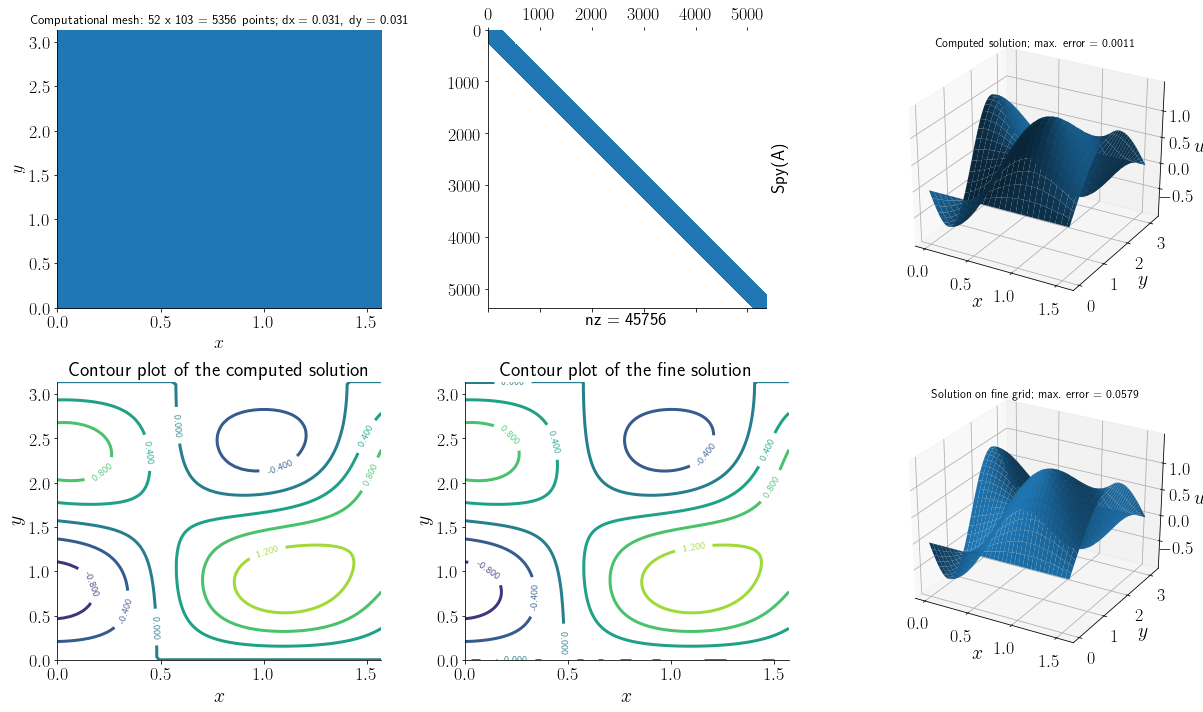

In [9]:
sample_q2b = q2b()
sample_q2b.get_plot("q2b_figure.pdf")

In [10]:
def q2b_compute_grid_error_scaling(n=9, with_corrections=False):
    
        # initialize array for storage
        Nvals = zeros(n)
        error_array1_infnorm = zeros(n)

        # set the number of initial number of internal points
        m_coarse = (2**2)

        print(f"N    inf-norm error    ratio (inf-norm)    order (inf-norm)")
        
        for i in range(n):

            # construct the meshes and solve 
            soln_coarse = q2b(m=m_coarse,with_corrections=with_corrections)

            # compute the errors using the infinity-norm
            error_array1_infnorm[i] = norm(
                soln_coarse.U.flatten()-soln_coarse.exact_soln(soln_coarse.xxn, soln_coarse.yyn).flatten(), 
                ord=inf
            )

            # record the number of intervals
            Nvals[i] = m_coarse + 1
            
            if (i > 0):
                print(
                    f"{m_coarse+1:<5d}"
                    + f"{error_array1_infnorm[i]:<18.2e}"
                    + f"{error_array1_infnorm[i]/error_array1_infnorm[i-1]:<20.5f}"
                    + f"{-log((error_array1_infnorm[i]/error_array1_infnorm[i-1]).__abs__())/log(2):<16.5f}"
                    )
            else:
                print(
                    f"{m_coarse+1:<5d}"
                    + f"{error_array1_infnorm[i]:<18.2e}"
                    )
                
            # set the current fine grid as the coarse grid for next iteration
            m_coarse = 2*m_coarse + 1

        return Nvals, error_array1_infnorm

In [11]:
def plot_2b():
    
    Nvals, error_array1_infnorm = q2b_compute_grid_error_scaling(n=6)

    fig, ax = subplots(1,1,figsize=(10,10))

    ax.loglog(Nvals, error_array1_infnorm, lw=3.0, label="inf-norm")

    ax.loglog(Nvals, 1./(Nvals**2), lw=3.0, ls="--", color="gray", label=r"reference $N^{-2}$ line")
    
    ax.legend(loc=0, prop={"size":18})
    ax.set_ylabel(r"$E(N)$", fontsize=28)
    ax.set_xlabel(r"$N$", fontsize=28)
    ax.tick_params(labelsize=28)
    ax.grid(True)

    fig.tight_layout()
    fig.savefig("q2b_err_fig.pdf")

N    inf-norm error    ratio (inf-norm)    order (inf-norm)
5    1.16e-01          
10   2.95e-02          0.25404             1.97689         
20   7.46e-03          0.25278             1.98405         
40   1.86e-03          0.24946             2.00310         
80   4.65e-04          0.24987             2.00078         
160  1.16e-04          0.24999             2.00004         


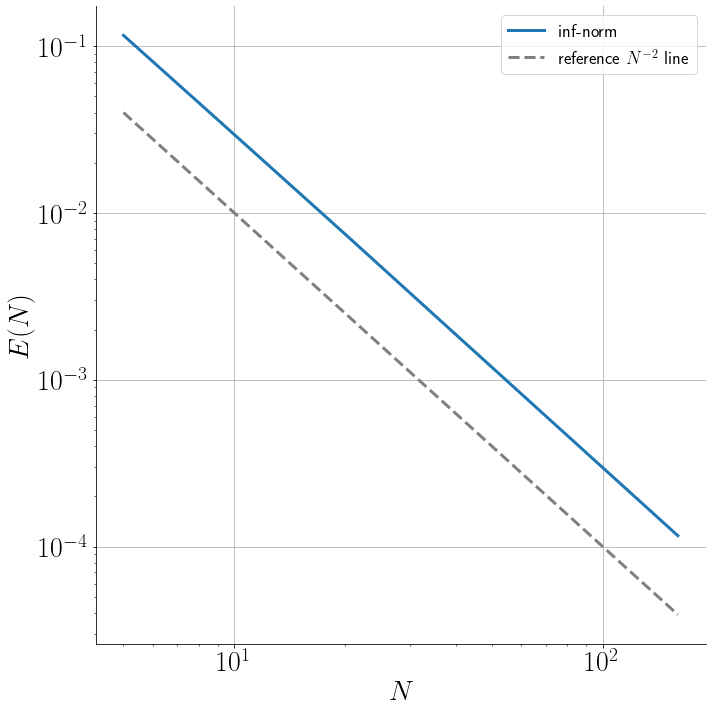

In [12]:
plot_2b()

In [13]:
def plot_2b_corrections():
    
    Nvals, error_array1_infnorm = q2b_compute_grid_error_scaling(n=6, with_corrections=True)

    fig, ax = subplots(1,1,figsize=(10,10))

    ax.loglog(Nvals, error_array1_infnorm, lw=3.0, label="inf-norm")

    ax.loglog(Nvals, 1./(Nvals**4), lw=3.0, ls="--", color="gray", label=r"reference $N^{-4}$ line")
    
    ax.legend(loc=0, prop={"size":18})
    ax.set_ylabel(r"$E(N)$", fontsize=28)
    ax.set_xlabel(r"$N$", fontsize=28)
    ax.tick_params(labelsize=28)
    ax.grid(True)

    fig.tight_layout()
    fig.savefig("q2b_deferred_err_fig.pdf")

N    inf-norm error    ratio (inf-norm)    order (inf-norm)
5    7.24e-03          
10   4.52e-04          0.06249             4.00013         
20   2.85e-05          0.06294             3.98992         
40   1.77e-06          0.06230             4.00458         
80   1.11e-07          0.06245             4.00114         
160  6.92e-09          0.06250             3.99999         


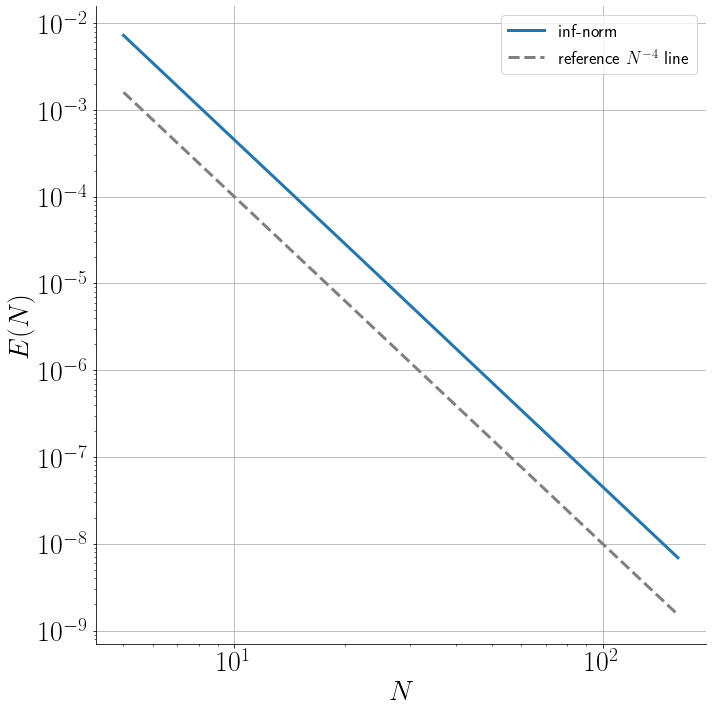

In [14]:
plot_2b_corrections()